




## Challenge 5

Fitting and checking predictions on the exact same data set can be misleading. Divide your data into two sets: a training and a test set (roughly 75% training, 25% test is a fine split). Fit a model on the training set, check the predictions (by plotting versus actual values) in the test set.

In [88]:
import os
import sys
import importlib
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import scipy.stats as stats

import redfin
import homepricemodels

importlib.reload(redfin)
importlib.reload(homepricemodels)



pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


import statsmodels.api as sm

from sklearn import datasets ## imports datasets from scikit-learn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso




import matplotlib.pyplot as plt

% matplotlib inline


In [50]:
!pwd
!ls

/Users/timcodes/ds/metis/metisgh/02_Luther/Luther
LICENSE
README.md
__pycache__
explore_luther.ipynb
geckodriver.log
homepricemodels.py
pickles
rappold_tim_challenge_05_linear_splitting.ipynb
redfin.py
redfin_2018-04-18-08-51-54.csv


In [19]:
#combined_home_stats = homepricemodels.load_all_home_stats(pickle_file='pickles/combined_home_stats.pkl')



df_clean = homepricemodels.clean_home_stats_df(combined_home_stats)
df_clean = homepricemodels.get_engineered_features(df_clean)

df = df_clean.copy()

df.shape

(4390, 47)

In [4]:
def diagnostic_plot(y_pred, y):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(y_pred, y)
    plt.plot(y_pred, y_pred, color='red', linewidth=1)
    plt.title("Predicted vs Actual")
    plt.xlabel("Y Predicted")
    plt.ylabel("Y Actual")

    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")

    plt.subplot(1, 3, 3)
    # Generates a probability plot of sample data against the quantiles of a
    # specified theoretical distribution
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
def sm_ols_wrapper(y, X):
    model = sm.OLS(y,X)
    results = model.fit()
    y_pred = results.predict(X)
    print(results.summary())
    diagnostic_plot(y_pred, y)
    return results


def get_gridsearch_lasso(X, y, test_size=0.3, random_state=0, score='r2', kfold=5):
    # Split the dataset into test and train.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0)

    # Set the parameters by cross-validation
    tuned_parameters = [{'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
                         'normalize': [True, False]}]


    print("# Tuning hyper-parameters for %s" % 'r2')
    print()

    reg = GridSearchCV(Lasso(), tuned_parameters, cv=kfold,
                       scoring=score)
    reg.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(reg.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = reg.cv_results_['mean_test_score']
    stds = reg.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, reg.cv_results_['params']):
        print("%0.4f (+/-%0.04f) for %r"
              % (mean, std * 2, params))
    print()
    return reg.best_params_

def get_lasso(X_train,y_train, alpha=alpha, normalize=normalize):
    reg = Lasso(alpha=alpha, normalize=True)
    reg.fit(X_train,y_train)
    
    for tup in list(zip(X_train.columns, reg.coef_)):
        print(tup)



## Challenge 1

Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

In [7]:
y = df['Sales Price']
X = pd.Series(1, index=df.index)

/Users/timcodes/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


                            OLS Regression Results                            
Dep. Variable:            Sales Price   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Wed, 25 Apr 2018   Prob (F-statistic):                nan
Time:                        16:37:05   Log-Likelihood:                -67984.
No. Observations:                4390   AIC:                         1.360e+05
Df Residuals:                    4389   BIC:                         1.360e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.141e+06   1.94e+04     58.779      0.0

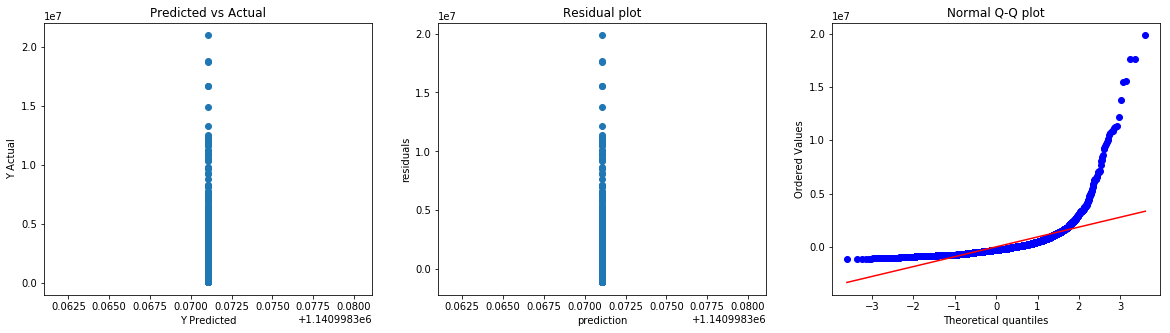

In [8]:
results = OLS_wrapper(y,X)


## Challenge 2

Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?

                            OLS Regression Results                            
Dep. Variable:            Sales Price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                 1.151e+04
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:37:14   Log-Likelihood:                -66433.
No. Observations:                4390   AIC:                         1.329e+05
Df Residuals:                    4389   BIC:                         1.329e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Total Sq. Ft.   703.0159      6.554    107.272

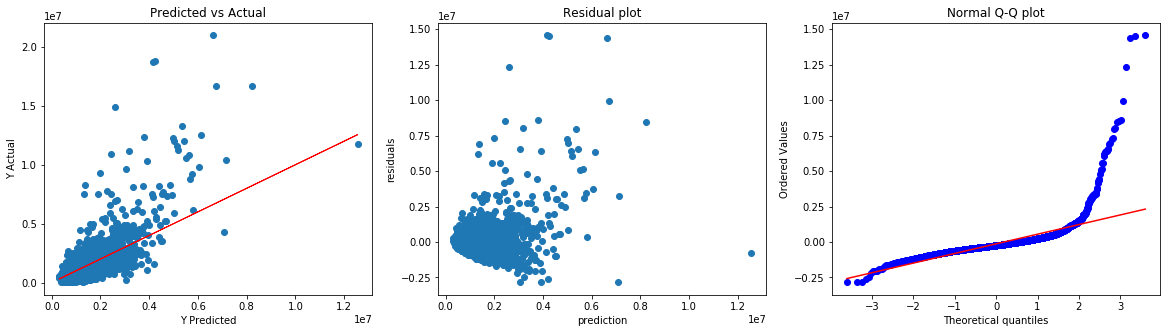

In [9]:
y = df['Sales Price']
X = df['Total Sq. Ft.']

results = sm_ols_wrapper(y, X)


## Challenge 3

Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?



(4390,)
(4390, 4)
                            OLS Regression Results                            
Dep. Variable:            Sales Price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     1761.
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:37:21   Log-Likelihood:                -66248.
No. Observations:                4390   AIC:                         1.325e+05
Df Residuals:                    4386   BIC:                         1.325e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Tota

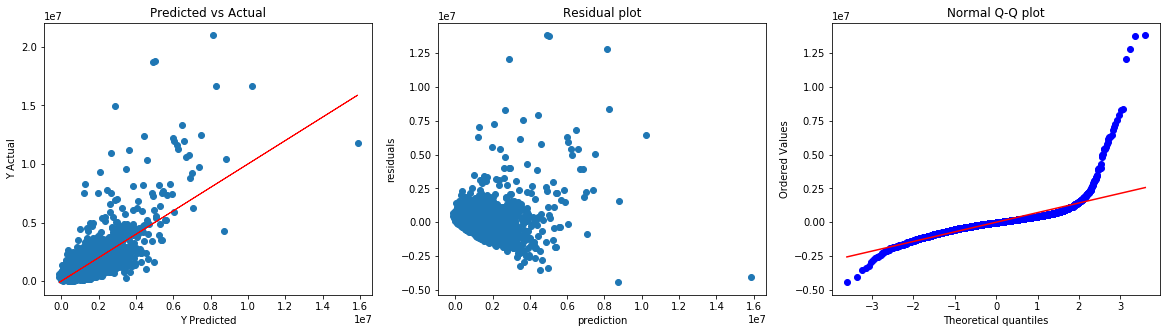

In [10]:
y = df['Sales Price']
X = df[['Total Sq. Ft.']+list(df['Style'].unique())]
print(y.shape)
print(X.shape)
results = sm_ols_wrapper(y, X)



(4390,)
(4390, 25)
                            OLS Regression Results                            
Dep. Variable:            Sales Price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     392.7
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:37:27   Log-Likelihood:                -65459.
No. Observations:                4390   AIC:                         1.310e+05
Df Residuals:                    4365   BIC:                         1.311e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Total Sq. Ft.   730.8909   

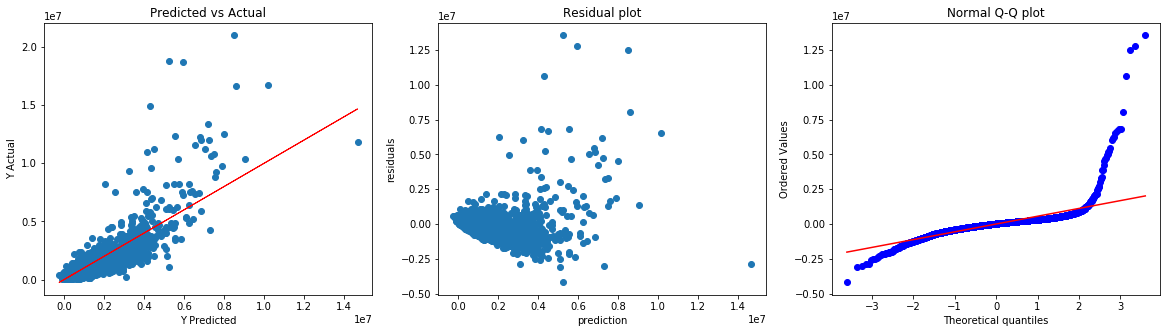

In [11]:
y = df['Sales Price']
X = df[['Total Sq. Ft.']+list(df['Zip Code'].unique())]
print(y.shape)
print(X.shape)
results = sm_ols_wrapper(y, X)

(4390,)
(4390, 3)
                            OLS Regression Results                            
Dep. Variable:            Sales Price   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     2858.
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:37:34   Log-Likelihood:                -66152.
No. Observations:                4390   AIC:                         1.323e+05
Df Residuals:                    4387   BIC:                         1.323e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Total Sq. Ft.   896.1250    

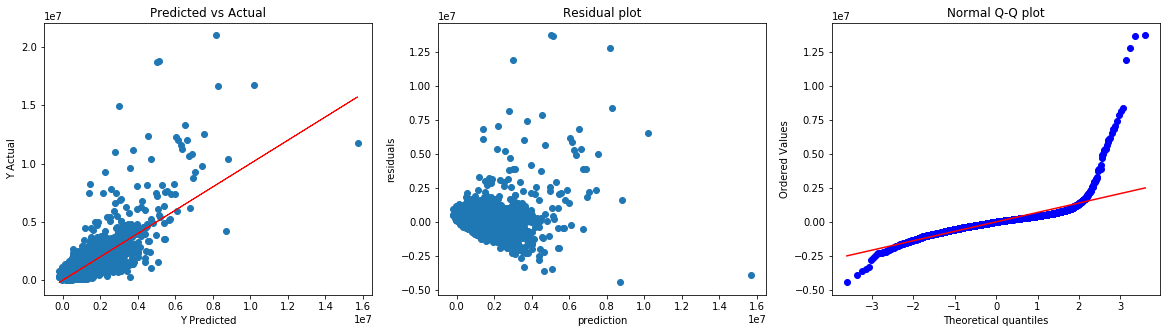

In [12]:
y = df['Sales Price']
X = df[['Total Sq. Ft.']+list(df['City'].unique())]
print(y.shape)
print(X.shape)
results = sm_ols_wrapper(y, X)

## Challenge 4

Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.



                            OLS Regression Results                            
Dep. Variable:        Log Sales Price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                 1.573e+04
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:37:43   Log-Likelihood:                -10707.
No. Observations:                4390   AIC:                         2.142e+04
Df Residuals:                    4389   BIC:                         2.142e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Total Sq. Ft.     0.0025   2.01e-05    125.432

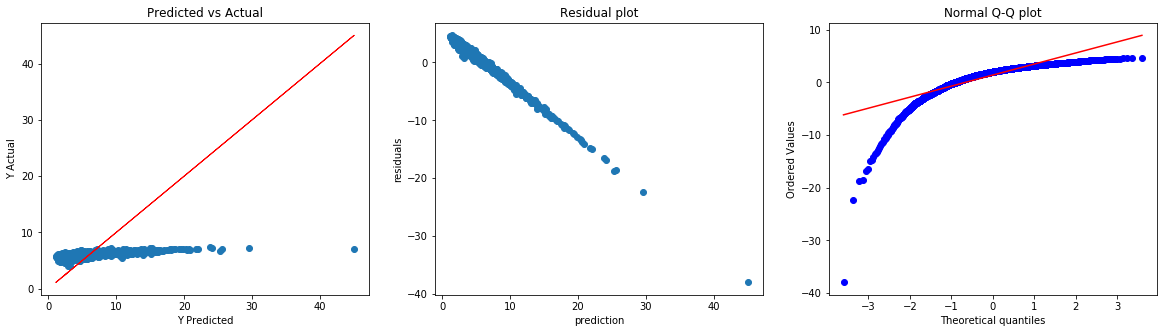

In [13]:
y = df['Log Sales Price']
X = df['Total Sq. Ft.']

results = sm_ols_wrapper(y, X)

                            OLS Regression Results                            
Dep. Variable:        Log Sales Price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     6059.
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:37:49   Log-Likelihood:                -10454.
No. Observations:                4390   AIC:                         2.091e+04
Df Residuals:                    4387   BIC:                         2.093e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Total Sq. Ft.        0.0011   6.46e-05  

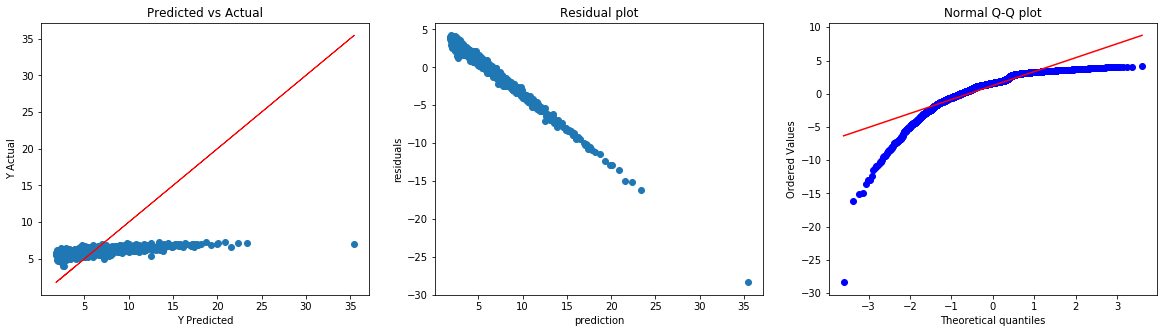

In [14]:
y = df['Log Sales Price']
X = df[['Total Sq. Ft.', 'Baths','Lot Size Sq. Ft.']]

results = sm_ols_wrapper(y, X)

                            OLS Regression Results                            
Dep. Variable:            Sales Price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     4069.
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:37:57   Log-Likelihood:                -66338.
No. Observations:                4390   AIC:                         1.327e+05
Df Residuals:                    4387   BIC:                         1.327e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Total Sq. Ft.   784.5647     22.060     35.565

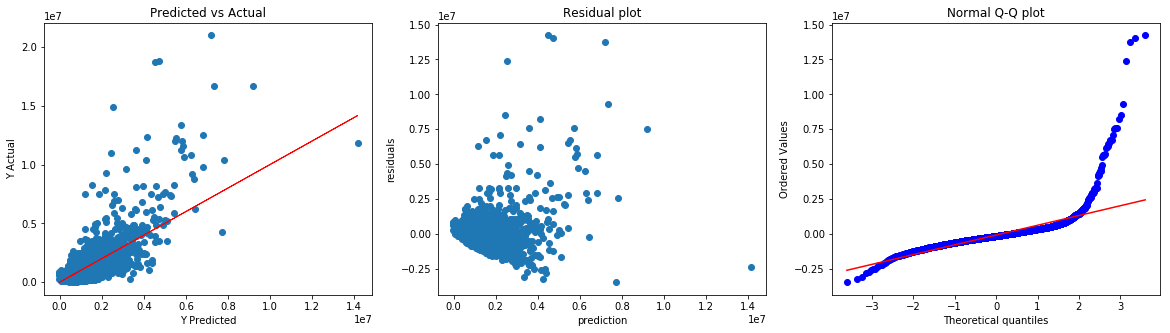

In [15]:
y = df['Sales Price']
X = df[['Total Sq. Ft.','Weeks ago','Baths']]


# X = df[['Total Sq. Ft.', 'Baths','Lot Size Sq. Ft.']]

results = sm_ols_wrapper(y, X)

In [16]:

df.columns
    

Index(['Baths', 'Beds', 'County', 'Last Sold', 'Sales Price', 'Style',
       'Total Sq. Ft.', 'Year Built', 'Year Renovated', 'Zip Code', 'rURL',
       'Lot Size Sq. Ft.', 'Weeks ago', 'City', 'Month Sold', 'Year Sold',
       'Log Sales Price', 'Condo/Co-op', 'Single Family Residential',
       'Townhouse', 'Los Angeles', 'Oakland', '90024', '90026', '90027',
       '90039', '90041', '90049', '90056', '90069', '90221', '90232', '90292',
       '90301', '90403', '94601', '94602', '94603', '94605', '94606', '94607',
       '94609', '94610', '94611', '94618', '94619'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:        Log Sales Price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     9652.
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:39:49   Log-Likelihood:                -9597.2
No. Observations:                4390   AIC:                         1.920e+04
Df Residuals:                    4387   BIC:                         1.922e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Total Sq. Ft.     0.0007   5.37e-05     13.331

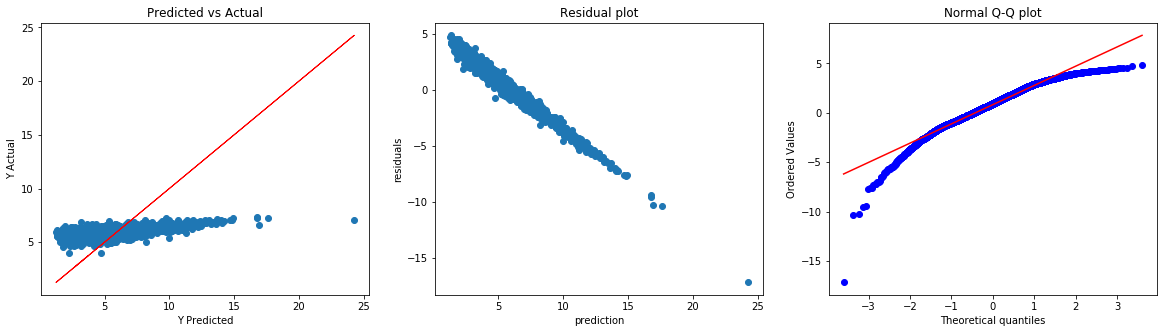

In [17]:
y = df['Log Sales Price']
X = df[['Total Sq. Ft.','Weeks ago','Baths']]


# X = df[['Total Sq. Ft.', 'Baths','Lot Size Sq. Ft.']]

results = sm_ols_wrapper(y, X)

                            OLS Regression Results                            
Dep. Variable:       Sqrt Sales Price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 1.601e+04
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:41:27   Log-Likelihood:                -31398.
No. Observations:                4390   AIC:                         6.280e+04
Df Residuals:                    4387   BIC:                         6.282e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Total Sq. Ft.     0.2862      0.008     37.116

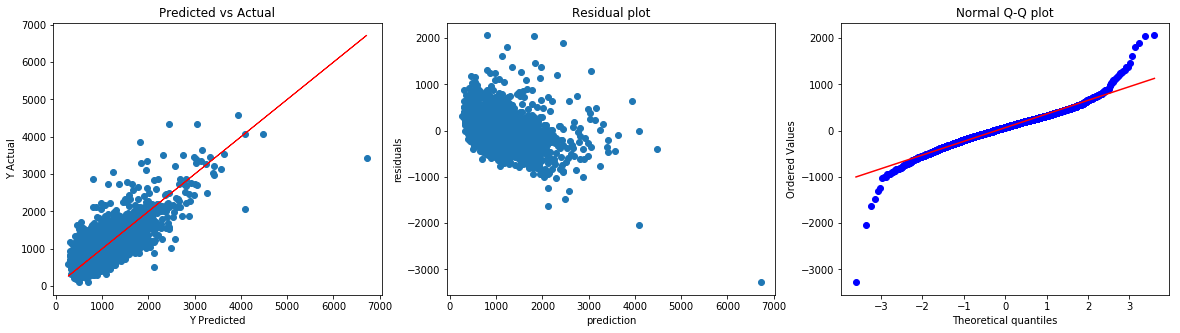

In [20]:
y = df['Sqrt Sales Price']
X = df[['Total Sq. Ft.','Weeks ago','Baths']]

results = OLS_wrapper(y, X)

                            OLS Regression Results                            
Dep. Variable:       Sqrt Sales Price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 1.202e+04
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:34:02   Log-Likelihood:                -31396.
No. Observations:                4390   AIC:                         6.280e+04
Df Residuals:                    4386   BIC:                         6.283e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Total Sq. Ft.        0.2871      0.008  

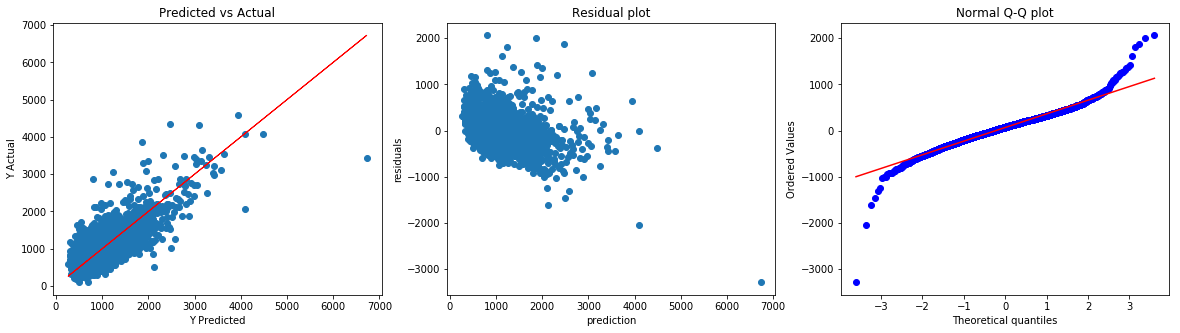

In [86]:
y = df['Sqrt Sales Price']
X = df[['Total Sq. Ft.', 'Weeks ago','Baths', 'Lot Size Sq. Ft.']]

results = OLS_wrapper(y, X)

In [90]:
results.pvalues

Total Sq. Ft.      0.0000
Weeks ago          0.0000
Baths              0.0000
Lot Size Sq. Ft.   0.0433
dtype: float64

In [ ]:
results

In [93]:
mask = (df['Sales Price']<3000000)&(df['Sales Price']>200000)


y = df[mask]['Sqrt Sales Price']

drop_strings = ['City','Zip Code','County','Style','Last Sold','rURL','Los Angeles','Oakland']
exclude_ys = ['Log Sales Price', 'Sqrt Sales Price', 'Sales Price']
exclude_bads = ['Beds','Month Sold','Year Sold','Condo/Co-op']


X = df.drop(drop_strings+exclude_ys+exclude_bads , axis=1)[mask]



In [101]:
print(__doc__)

    



Automatically created module for IPython interactive environment


In [95]:
reg = Lasso(alpha= 0.0001, normalize=True)
reg.fit(X_train,y_train)

for tup in list(zip(X_train.columns, reg.coef_)):
    print(tup)


('Baths', 4.534037367377559)
('Total Sq. Ft.', 0.15660649200724486)
('Year Built', -0.5499984175737048)
('Year Renovated', 0.4762120638477666)
('Lot Size Sq. Ft.', -3.53519027648343e-05)
('Weeks ago', 0.6985551582667966)
('Single Family Residential', 112.70620561703454)
('Townhouse', -76.20967394091628)
('90024', 316.5734177092753)
('90026', 54.918834546639346)
('90027', 183.51627363066336)
('90039', 103.66172223330769)
('90041', -7.363465069938865)
('90049', 391.93250425472485)
('90056', -61.64980500913672)
('90069', 387.6570461102133)
('90221', -278.4069290516116)
('90232', 192.0602875037065)
('90292', 240.2552636410985)
('90301', -181.32287380907104)
('90403', 483.06070246800664)
('94601', -188.5228061608415)
('94602', -0.0)
('94603', -251.0321179998415)
('94605', -150.00294105555628)
('94606', -131.6789232977833)
('94607', -132.52153273561308)
('94609', 71.95791686389256)
('94610', 127.35413472135807)
('94611', 98.13645510150178)
('94618', 192.56601170177674)
('94619', -82.10017600

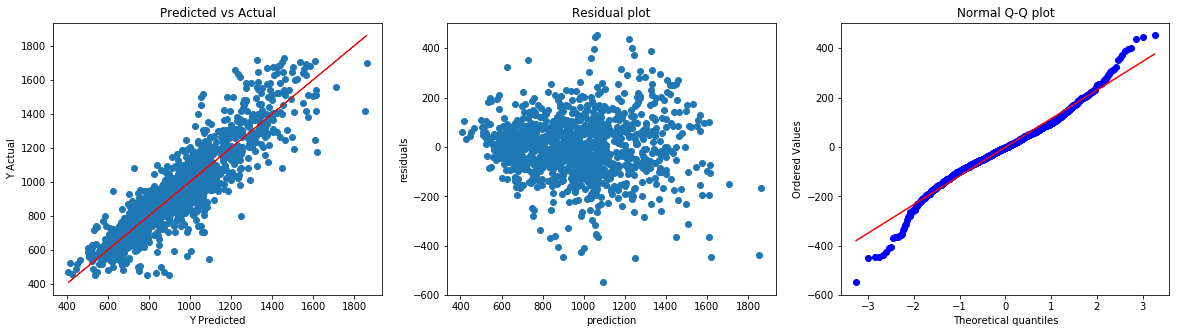

In [96]:
y_pred = reg.predict(X_test)

diagnostic_plot(y_pred, y_test)

In [55]:
mape = (abs((y_test-y_pred)/y_test)).mean()

In [97]:
mape

0.12040393016872866

In [43]:
import numpy as np
np.logspace(-5,-3,5)

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03])

In [103]:
y = df[mask]['Sales Price']

drop_strings = ['City','Zip Code','County','Style','Last Sold','rURL','Los Angeles','Oakland']
exclude_ys = ['Log Sales Price', 'Sqrt Sales Price', 'Sales Price']


X = df.drop(drop_strings+exclude_ys, axis=1)[mask]


# Split the dataset into test and train.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
                     'normalize': [True, False]}]


print("# Tuning hyper-parameters for %s" % 'r2')
print()

reg = GridSearchCV(Lasso(), tuned_parameters, cv=5,
                   scoring='r2')
reg.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(reg.best_params_)
print()
print("Grid scores on development set:")
print()
means = reg.cv_results_['mean_test_score']
stds = reg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, reg.cv_results_['params']):
    print("%0.4f (+/-%0.04f) for %r"
          % (mean, std * 2, params))
print()



# Tuning hyper-parameters for r2



/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

Best parameters set found on development set:

{'alpha': 1, 'normalize': True}

Grid scores on development set:

0.7595 (+/-0.0391) for {'alpha': 1, 'normalize': True}
0.7594 (+/-0.0389) for {'alpha': 1, 'normalize': False}
0.7594 (+/-0.0392) for {'alpha': 10, 'normalize': True}
0.7594 (+/-0.0390) for {'alpha': 10, 'normalize': False}
0.7591 (+/-0.0392) for {'alpha': 30, 'normalize': True}
0.7595 (+/-0.0391) for {'alpha': 30, 'normalize': False}
0.7569 (+/-0.0391) for {'alpha': 100, 'normalize': True}
0.7594 (+/-0.0396) for {'alpha': 100, 'normalize': False}



In [67]:
reg = Lasso(alpha= 10, normalize=True)
reg.fit(X_train,y_train)

for tup in list(zip(X_train.columns, reg.coef_)):
    print(tup)

('Baths', 20740.323823270974)
('Beds', -22130.73617392806)
('Total Sq. Ft.', 412.4273634614838)
('Year Built', -2223.446867045591)
('Year Renovated', 1287.6960703252757)
('Lot Size Sq. Ft.', -0.3113366612958773)
('Weeks ago', 1210.0121214680148)
('Month Sold', 426.97194971841753)
('Year Sold', 0.0)
('Condo/Co-op', 80048.32168270592)
('Single Family Residential', 234942.15711440993)
('Townhouse', -215612.2177620056)
('90024', 972850.3141374274)
('90026', 14732.66773820315)
('90027', 252172.17158906165)
('90039', 90322.62570297746)
('90041', -104583.45757614459)
('90049', 991297.19545782)
('90056', -305911.6128435672)
('90069', 968189.3075894666)
('90221', -470424.8953509961)
('90232', 308665.5855134759)
('90292', 506959.1690499391)
('90301', -286900.7152580282)
('90403', 1080643.1507485504)
('94601', -421051.9515761414)
('94602', -133104.27944888046)
('94603', -444779.30189975415)
('94605', -352702.0618845008)
('94606', -331360.3408382615)
('94607', -317166.95493992086)
('94609', 25399.

/Users/timcodes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


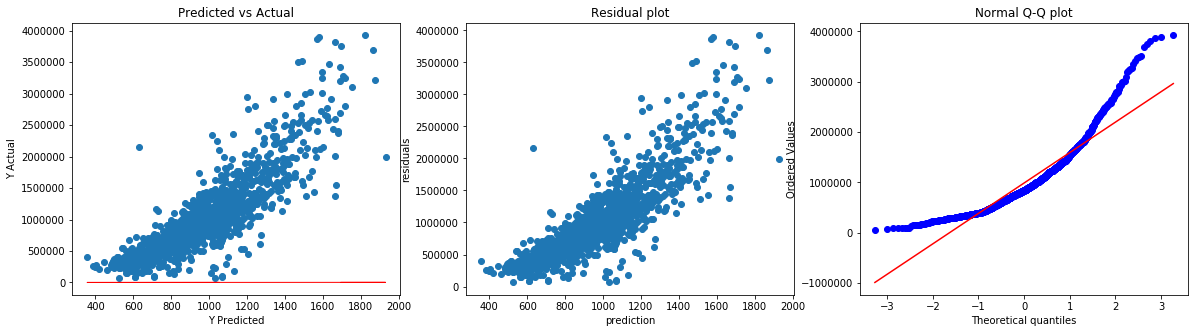

In [68]:
diagnostic_plot(y_pred, y_test)